In [12]:
!scala -version



Scala code runner version 2.12.10 -- Copyright 2002-2019, LAMP/EPFL and Lightbend, Inc.


In [13]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName('BigQuery Storage & Spark DataFrames') \
    .config('spark.jars', 'gs://spark-lib/bigquery/spark-bigquery-latest_2.12.jar') \
    .getOrCreate()

In [14]:
spark.conf.set("spark.sql.repl.eagerEval.enabled", True)


In [15]:
table = "bigquery-public-data.wikipedia.pageviews_2020"
df_wiki_pageviews = spark.read \
    .format("bigquery") \
    .option("table", table) \
    .option("filter", "datehour >= '2020-03-01' AND datehour < '2020-03-02'") \
    .load()

df_wiki_pageviews.printSchema()

root
 |-- datehour: timestamp (nullable = true)
 |-- wiki: string (nullable = true)
 |-- title: string (nullable = true)
 |-- views: long (nullable = true)



In [16]:
'''\
I got a fright from how many rows of the column-title was empty. So I added two more conditions in the .where clause which filtered out the rows with empty titles
'''

df_wiki_en = df_wiki_pageviews \
  .select("datehour", "wiki", "views") \
  .where("views > 1000 AND wiki in ('en', 'en.m') AND title IS NOT NULL AND title != '-'") \
  .cache()

df_wiki_en.show()


+-------------------+----+-----+
|           datehour|wiki|views|
+-------------------+----+-----+
|2020-03-01 20:00:00|  en| 1124|
|2020-03-01 16:00:00|  en| 1098|
|2020-03-01 16:00:00|  en| 1864|
|2020-03-01 16:00:00|  en| 1147|
|2020-03-01 16:00:00|  en| 1421|
|2020-03-01 16:00:00|  en| 2897|
|2020-03-01 16:00:00|  en| 3932|
|2020-03-01 16:00:00|  en| 1244|
|2020-03-01 16:00:00|  en| 1160|
|2020-03-01 16:00:00|  en| 8864|
|2020-03-01 16:00:00|  en| 1304|
|2020-03-01 16:00:00|  en| 1007|
|2020-03-01 16:00:00|  en| 2390|
|2020-03-01 02:00:00|  en| 1580|
|2020-03-01 02:00:00|  en| 5411|
|2020-03-01 02:00:00|  en| 1652|
|2020-03-01 02:00:00|  en| 1291|
|2020-03-01 02:00:00|  en| 1569|
|2020-03-01 02:00:00|  en| 1506|
|2020-03-01 02:00:00|  en| 6971|
+-------------------+----+-----+
only showing top 20 rows



In [28]:
import pyspark.sql.functions as F

df_datehour_totals = df_wiki_en \
.groupBy("datehour") \
.agg(F.sum('views').alias('total_views'))

df_datehour_totals.orderBy('total_views', ascending=False)

datehour,total_views
2020-03-01 21:00:00,1406789
2020-03-01 06:00:00,1379540
2020-03-01 17:00:00,1358902
2020-03-01 22:00:00,1335796
2020-03-01 05:00:00,1328237
2020-03-01 16:00:00,1319909
2020-03-01 03:00:00,1302860
2020-03-01 18:00:00,1282286
2020-03-01 04:00:00,1275242
2020-03-01 15:00:00,1258813


In [30]:
spark.conf.set("spark.sql.execution.arrow.enabled", "true")
%time pandas_datehour_totals = df_datehour_totals.toPandas()

pandas_datehour_totals.set_index('datehour', inplace=True)
pandas_datehour_totals.head()

CPU times: user 9.66 ms, sys: 237 µs, total: 9.9 ms
Wall time: 1.06 s


,total_views
datehour,
2020-03-01 22:00:00,1335796
2020-03-01 09:00:00,1070576
2020-03-01 12:00:00,1001834
2020-03-01 20:00:00,1211378
2020-03-01 10:00:00,1059262


In [31]:
import matplotlib.pyplot as plt

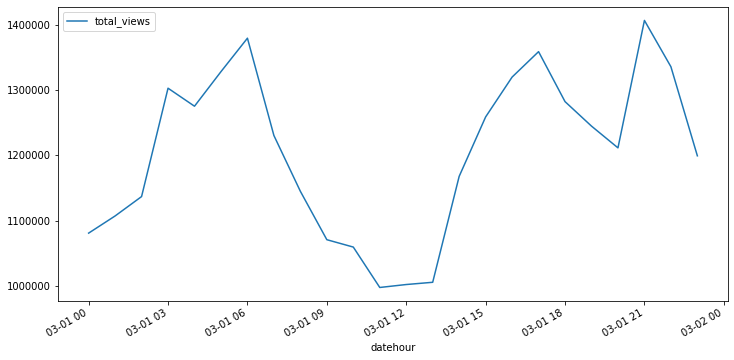

In [32]:
pandas_datehour_totals.plot(kind='line',figsize=(12,6))

In [33]:
import pyspark.sql.functions as F

df_wiki_totals = df_wiki_en \
.groupBy("datehour") \
.pivot("wiki") \
.agg(F.sum('views').alias('total_views'))

df_wiki_totals

datehour,en,en.m
2020-03-01 22:00:00,372962,962834
2020-03-01 09:00:00,528168,542408
2020-03-01 12:00:00,430811,571023
2020-03-01 20:00:00,395171,816207
2020-03-01 05:00:00,463108,865129
2020-03-01 10:00:00,512994,546268
2020-03-01 14:00:00,502515,665158
2020-03-01 19:00:00,436201,808524
2020-03-01 03:00:00,368810,934050
2020-03-01 01:00:00,336984,769983


In [34]:
pandas_wiki_totals = df_wiki_totals.toPandas()

pandas_wiki_totals.set_index('datehour', inplace=True)
pandas_wiki_totals.head()


,en,en.m
datehour,,
2020-03-01 22:00:00,372962,962834
2020-03-01 09:00:00,528168,542408
2020-03-01 12:00:00,430811,571023
2020-03-01 20:00:00,395171,816207
2020-03-01 05:00:00,463108,865129


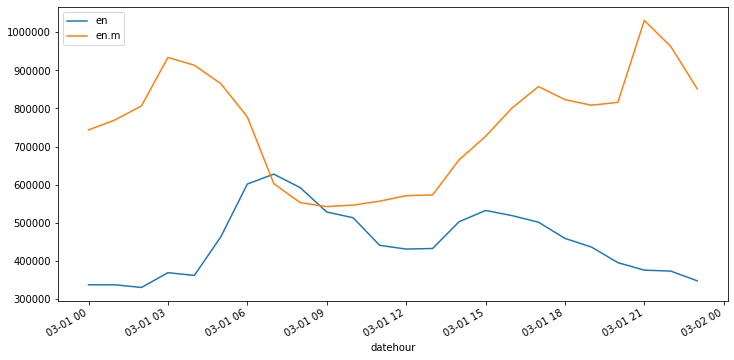

In [35]:
pandas_wiki_totals.plot(kind='line',figsize=(12,6))

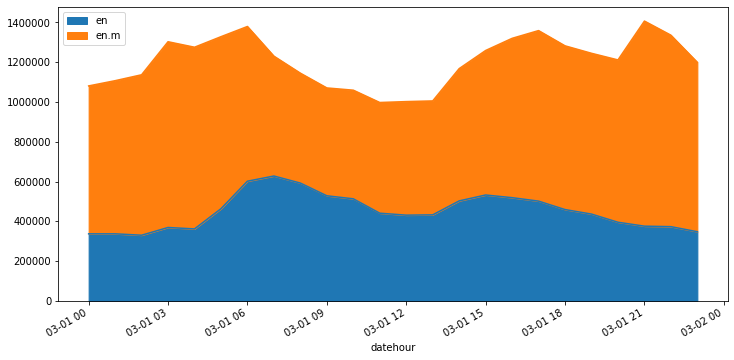

In [36]:
pandas_wiki_totals.plot.area(figsize=(12,6))